# 04 — Feature Engineering

Applies EDA-driven recommendations to produce the final processed dataset for ML training:
1. Load `eda_recommendations.json` from notebook 03
2. Review and optionally override recommendations
3. Apply log1p transforms to skewed features
4. Drop redundant features (high inter-feature correlation)
5. Drop low-signal features (low MI + low linear correlation with target)
6. Re-run target creation, splitting, and normalization
7. Save final processed files (overwrites notebook 02 output)

In [1]:
import sys
import os
import json
import pickle
from pathlib import Path

PROJECT_FOLDER = "spy_run"
PROJECT_ROOT   = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

DATA_CONFIG   = PROJECT_ROOT / "config" / PROJECT_FOLDER / "data_config.json"
MODEL_CONFIG  = PROJECT_ROOT / "config" / PROJECT_FOLDER / "model_config.json"
RAW_PARQUET   = PROJECT_ROOT / "data" / "raw" / f"{PROJECT_FOLDER}_raw.parquet"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / PROJECT_FOLDER
RESULTS_DIR   = PROJECT_ROOT / "results" / PROJECT_FOLDER
RECS_PATH     = RESULTS_DIR / "eda_recommendations.json"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project folder : {PROJECT_FOLDER}")
print(f"Recommendations: {RECS_PATH}")

Project folder : spy_run
Recommendations: /Users/sharannaribole/Documents/github/stock-return-classifier/results/spy_run/eda_recommendations.json


## Load EDA Recommendations

In [2]:
with open(RECS_PATH) as f:
    recs = json.load(f)

print(f"Recommendations generated: {recs['generated_at']}")
print(f"Thresholds used:")
for k, v in recs['thresholds'].items():
    print(f"  {k}: {v}")
print()

print("── log1p Transform Candidates ─────────────────────────────────")
for f, skew in recs['log1p_transforms']['skewness'].items():
    print(f"  {f:<22} skewness = {skew}")
print()

print("── Redundant Features (high inter-feature correlation) ─────────")
print("  High-correlation pairs:")
for p in recs['redundant_features']['high_corr_pairs']:
    print(f"    {p['feature_a']:<20} <-> {p['feature_b']:<20}  |r|={p['correlation']}")
print(f"  Recommended drops: {recs['redundant_features']['recommended_drops']}")
print()

print("── Low-Signal Features (low MI + low linear correlation) ───────")
for f, d in recs['low_signal_features']['details'].items():
    print(f"  {f:<22} lin_corr={d['lin_corr']}  MI={d['mi_score']}")
print(f"  Recommended drops: {recs['low_signal_features']['recommended_drops']}")

Recommendations generated: 2026-02-18
Thresholds used:
  skewness_for_log1p: 1.0
  correlation_for_redundancy: 0.85
  lin_corr_for_low_signal: 0.02
  mi_for_low_signal: 0.001

── log1p Transform Candidates ─────────────────────────────────
  ATR_pct                skewness = 3.174
  BB_Width               skewness = 3.326
  MACD_line              skewness = -1.631
  MACD_signal            skewness = -1.538
  VIX_Close              skewness = 2.419
  Volume                 skewness = 2.29

── Redundant Features (high inter-feature correlation) ─────────
  High-correlation pairs:
    VIX_Close            <-> ATR_pct               |r|=0.9406
    Close                <-> BB_High               |r|=0.9975
    Close                <-> BB_Low                |r|=0.9984
    Close                <-> EMA_8                 |r|=0.9997
    Close                <-> EMA_21                |r|=0.999
    BB_High              <-> BB_Low                |r|=0.9968
    BB_High              <-> EMA_8          

## User Override Section

Review the recommendations above and adjust the lists below before proceeding.
Set any list to `[]` to skip that step.

In [3]:
# ── Adjust these lists based on your review of the EDA ────────────────────────

# Features to apply log1p transform (must be >= 0 after transform)
LOG1P_FEATURES = recs['log1p_transforms']['recommended']

# Features to drop due to high inter-feature correlation
REDUNDANT_DROP = recs['redundant_features']['recommended_drops']

# Features to drop due to low predictive signal
LOW_SIGNAL_DROP = recs['low_signal_features']['recommended_drops']

# ─────────────────────────────────────────────────────────────────────────────
# 'Close' is always required for target computation — never drop it
PROTECTED_COLS = ["Close"]

# Combined final drop list (deduped, protected columns excluded)
ALL_DROPS = sorted(set(REDUNDANT_DROP + LOW_SIGNAL_DROP) - set(PROTECTED_COLS))

print("Final feature engineering plan:")
print(f"  log1p transforms : {LOG1P_FEATURES}")
print(f"  Redundant drops  : {REDUNDANT_DROP}")
print(f"  Low-signal drops : {LOW_SIGNAL_DROP}")
print(f"  Protected cols   : {PROTECTED_COLS}")
print(f"  Total drops      : {ALL_DROPS}")

Final feature engineering plan:
  log1p transforms : ['ATR_pct', 'BB_Width', 'MACD_line', 'MACD_signal', 'VIX_Close', 'Volume']
  Redundant drops  : ['ATR_pct', 'Close', 'BB_Low', 'EMA_8', 'EMA_21', 'BB_Width', 'BB_Position', 'Stoch_K', 'Stoch_D', 'MACD_signal', 'Price_Return_5']
  Low-signal drops : []
  Protected cols   : ['Close']
  Total drops      : ['ATR_pct', 'BB_Low', 'BB_Position', 'BB_Width', 'EMA_21', 'EMA_8', 'MACD_signal', 'Price_Return_5', 'Stoch_D', 'Stoch_K']


## Load Raw Data and Apply Base Feature Engineering

In [4]:
import pandas as pd
import numpy as np
from src.utils.config_loader import ConfigLoader
from src.features.engineer import FeatureEngineer
from src.features.target import TargetCreator

config   = ConfigLoader(str(DATA_CONFIG), str(MODEL_CONFIG))
engineer = FeatureEngineer(config)

raw_df   = pd.read_parquet(RAW_PARQUET)
feat_df  = engineer.create_features(raw_df)

# Create target from raw (pre-log1p) Close — must happen before any transforms
# so that forward returns are computed on actual prices, not compressed values.
target_creator = TargetCreator.from_config(config)
feat_df = target_creator.create_target(feat_df)

print(f"Raw shape        : {raw_df.shape}")
print(f"After features   : {feat_df.shape}")
print(f"Columns          : {list(feat_df.columns)}")

Raw shape        : (5119, 5)
After features   : (5085, 24)
Columns          : ['Volume', 'VIX_Close', 'Close', 'BB_High', 'BB_Low', 'BB_Width', 'BB_Position', 'EMA_8', 'EMA_21', 'ADX', 'RSI', 'MACD_line', 'MACD_signal', 'MACD_hist', 'Stoch_K', 'Stoch_D', 'ROC_3', 'ROC_5', 'Price_Return_1', 'Price_Return_5', 'IBS', 'ATR_pct', 'forward_return', 'target']


## Apply log1p Transforms

In [5]:

feat_df = feat_df.copy()

# Features that legitimately cross zero (oscillators) — use signed log1p instead
# signed_log1p(x) = sign(x) * log1p(|x|)  — symmetric compression of both tails
SIGNED_LOG1P_FEATURES = ["MACD_line", "MACD_signal", "MACD_hist",
                          "Price_Return_1", "Price_Return_5", "ROC_3", "ROC_5"]

applied        = []   # standard log1p
applied_signed = []   # signed log1p

for col in LOG1P_FEATURES:
    if col not in feat_df.columns:
        print(f"  NOTE: {col} not found — skipped")
        continue

    neg_count = (feat_df[col] < 0).sum()

    if col in SIGNED_LOG1P_FEATURES:
        # Oscillator: apply signed log1p regardless of sign
        feat_df[col] = np.sign(feat_df[col]) * np.log1p(np.abs(feat_df[col]))
        applied_signed.append(col)
        print(f"  signed log1p applied : {col}  (oscillator — crosses zero by design)")
    elif neg_count > 0:
        print(f"  WARNING: {col} has {neg_count} negative values — skipped (investigate)")
    else:
        feat_df[col] = np.log1p(feat_df[col])
        applied.append(col)

all_transformed = applied + applied_signed
print()
print(f"Standard  log1p applied to : {applied}")
print(f"Signed    log1p applied to : {applied_signed}")


  signed log1p applied : MACD_line  (oscillator — crosses zero by design)
  signed log1p applied : MACD_signal  (oscillator — crosses zero by design)

Standard  log1p applied to : ['ATR_pct', 'BB_Width', 'VIX_Close', 'Volume']
Signed    log1p applied to : ['MACD_line', 'MACD_signal']


### log1p Effect: Distribution Plots and Skewness Comparison

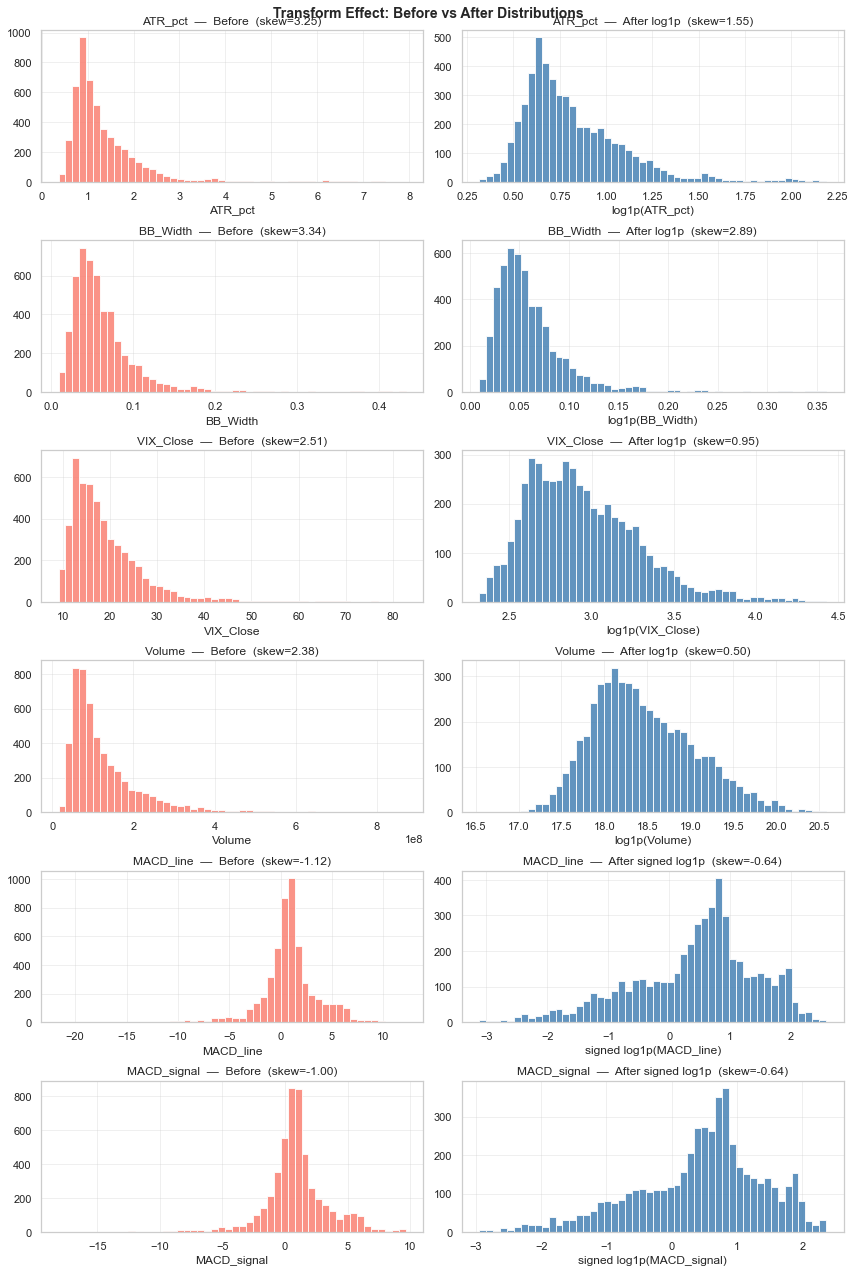

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.facecolor"]  = "white"
plt.rcParams["axes.facecolor"]    = "white"
plt.rcParams["savefig.facecolor"] = "white"

if all_transformed:
    raw_for_plot = engineer.create_features(raw_df)  # untransformed copy
    n = len(all_transformed)
    fig, axes = plt.subplots(n, 2, figsize=(12, n * 3))
    if n == 1:
        axes = [axes]

    for i, col in enumerate(all_transformed):
        raw_vals  = raw_for_plot[col].dropna()
        tran_vals = feat_df[col].dropna()
        kind      = "signed log1p" if col in applied_signed else "log1p"

        axes[i][0].hist(raw_vals,  bins=50, color="salmon",    edgecolor="white", alpha=0.85)
        axes[i][0].set_title(f"{col}  —  Before  (skew={raw_vals.skew():.2f})")
        axes[i][0].set_xlabel(col)
        axes[i][0].grid(True, alpha=0.3)

        axes[i][1].hist(tran_vals, bins=50, color="steelblue", edgecolor="white", alpha=0.85)
        axes[i][1].set_title(f"{col}  —  After {kind}  (skew={tran_vals.skew():.2f})")
        axes[i][1].set_xlabel(f"{kind}({col})")
        axes[i][1].grid(True, alpha=0.3)

    plt.suptitle("Transform Effect: Before vs After Distributions", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "fe_log1p_distributions.png", dpi=150, bbox_inches="tight", facecolor="white")
    plt.show()
else:
    print("No transforms were applied.")

In [7]:

# ── Skewness Comparison Table ─────────────────────────────────────────────────
if all_transformed:
    raw_for_skew = engineer.create_features(raw_df)

    print(f"{'Feature':<22} {'Transform':<14} {'Skew Before':>12} {'Skew After':>12}  {'Change':>10}  OK?")
    print("-" * 80)
    for col in all_transformed:
        kind   = "signed log1p" if col in applied_signed else "log1p"
        before = raw_for_skew[col].skew()
        after  = feat_df[col].skew()
        delta  = after - before
        ok     = "✓ improved" if abs(after) < abs(before) else "✗ check"
        print(f"{col:<22} {kind:<14} {before:>12.3f} {after:>12.3f}  {delta:>+10.3f}  {ok}")
else:
    print("No transforms were applied.")


Feature                Transform       Skew Before   Skew After      Change  OK?
--------------------------------------------------------------------------------
ATR_pct                log1p                 3.248        1.551      -1.697  ✓ improved
BB_Width               log1p                 3.337        2.890      -0.447  ✓ improved
VIX_Close              log1p                 2.515        0.949      -1.566  ✓ improved
Volume                 log1p                 2.376        0.495      -1.881  ✓ improved
MACD_line              signed log1p         -1.123       -0.638      +0.484  ✓ improved
MACD_signal            signed log1p         -0.997       -0.640      +0.357  ✓ improved


## Drop Redundant and Low-Signal Features

In [8]:
existing_drops = [c for c in ALL_DROPS if c in feat_df.columns]
missing_drops  = [c for c in ALL_DROPS if c not in feat_df.columns]

if missing_drops:
    print(f"  Note: columns not found (already absent): {missing_drops}")

feat_df.drop(columns=existing_drops, inplace=True)

NON_FEATURE_COLS = {"target", "forward_return"}
feature_cols = [c for c in feat_df.columns if c not in NON_FEATURE_COLS]
print(f"Dropped          : {existing_drops}")
print(f"Remaining columns: {feat_df.shape[1]} total, {len(feature_cols)} features")
print(f"Final features   : {feature_cols}")

Dropped          : ['ATR_pct', 'BB_Low', 'BB_Position', 'BB_Width', 'EMA_21', 'EMA_8', 'MACD_signal', 'Price_Return_5', 'Stoch_D', 'Stoch_K']
Remaining columns: 14 total, 12 features
Final features   : ['Volume', 'VIX_Close', 'Close', 'BB_High', 'ADX', 'RSI', 'MACD_line', 'MACD_hist', 'ROC_3', 'ROC_5', 'Price_Return_1', 'IBS']


## Create Target

In [9]:
# Target was already created above from raw Close (before log1p transforms).
# Display class balance.
counts = feat_df["target"].value_counts()
total  = len(feat_df)
print(f"Dataset shape after target creation: {feat_df.shape}")
print(f"Class 0: {counts.get(0,0):,}  ({counts.get(0,0)/total*100:.1f}%)")
print(f"Class 1: {counts.get(1,0):,}  ({counts.get(1,0)/total*100:.1f}%)")

Dataset shape after target creation: (5085, 14)
Class 0: 4,390  (86.3%)
Class 1: 695  (13.7%)


## Split into Train / Validation Folds / Test

In [10]:

from src.data.splitter import DataSplitter

splitter = DataSplitter(config)
train_df, val_folds, test_df = splitter.split(feat_df)

info = splitter.get_split_info(train_df, val_folds, test_df)
print(f"Train : {info['train_size']:,} rows  ({info['train_start']} to {info['train_end']})")
print(f"Test  : {info['test_size']:,} rows   ({info['test_start']} to {info['test_end']})")
print(f"Val folds ({info['n_val_folds']})  : {info['val_fold_sizes']}")


Train : 4,583 rows  (2005-11-25 to 2024-02-12)
Test  : 502 rows   (2024-02-13 to 2026-02-12)
Val folds (5)  : [763, 763, 763, 763, 763]


## Apply Normalization

In [11]:

from src.features.normalizer import Normalizer

normalizer = Normalizer.from_config(config)

train_norm_df, val_norm_folds, test_norm_df = normalizer.fit_transform(
    train_df, val_folds, test_df
)

print(f"Normalization method : {normalizer.method}")
print(f"Train (normalized)   : {train_norm_df.shape}")
print(f"Test  (normalized)   : {test_norm_df.shape}")
print(f"Val folds normalized : {len(val_norm_folds)} folds")


Normalization method : rolling
Train (normalized)   : (4583, 14)
Test  (normalized)   : (502, 14)
Val folds normalized : 5 folds


## Save Final Processed Files

In [12]:
NON_FEATURE_COLS = {"target", "forward_return"}
feature_cols_final = [c for c in train_norm_df.columns if c not in NON_FEATURE_COLS]

train_norm_df.to_parquet(PROCESSED_DIR / "train.parquet")
test_norm_df.to_parquet(PROCESSED_DIR / "test.parquet")

with open(PROCESSED_DIR / "val_folds.pkl", "wb") as f:
    pickle.dump(val_norm_folds, f)

target_info  = config.get("target") or {}
split_info   = splitter.get_split_info(train_df, val_folds, test_df)
train_counts = feat_df.loc[train_df.index, "target"].value_counts().to_dict()

metadata = {
    "feature_cols":      feature_cols_final,
    "n_features":        len(feature_cols_final),
    "target_info":       target_info,
    "class_counts":      {str(k): int(v) for k, v in train_counts.items()},
    "split_info":        split_info,
    "feature_engineering": {
        "log1p_applied":  applied,
        "dropped":        existing_drops,
    },
    "normalization":     normalizer.method,
}

with open(PROCESSED_DIR / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2, default=str)

print("Saved:")
print(f"  {PROCESSED_DIR / 'train.parquet'}")
print(f"  {PROCESSED_DIR / 'test.parquet'}")
print(f"  {PROCESSED_DIR / 'val_folds.pkl'}")
print(f"  {PROCESSED_DIR / 'metadata.json'}")
print()
print(f"Final feature set ({len(feature_cols_final)} features): {feature_cols_final}")
print(f"log1p applied to : {applied}")
print(f"Dropped          : {existing_drops}")

Saved:
  /Users/sharannaribole/Documents/github/stock-return-classifier/data/processed/spy_run/train.parquet
  /Users/sharannaribole/Documents/github/stock-return-classifier/data/processed/spy_run/test.parquet
  /Users/sharannaribole/Documents/github/stock-return-classifier/data/processed/spy_run/val_folds.pkl
  /Users/sharannaribole/Documents/github/stock-return-classifier/data/processed/spy_run/metadata.json

Final feature set (12 features): ['Volume', 'VIX_Close', 'Close', 'BB_High', 'ADX', 'RSI', 'MACD_line', 'MACD_hist', 'ROC_3', 'ROC_5', 'Price_Return_1', 'IBS']
log1p applied to : ['ATR_pct', 'BB_Width', 'VIX_Close', 'Volume']
Dropped          : ['ATR_pct', 'BB_Low', 'BB_Position', 'BB_Width', 'EMA_21', 'EMA_8', 'MACD_signal', 'Price_Return_5', 'Stoch_D', 'Stoch_K']
